In [1]:
import matplotlib.pyplot as plt
import struct
import pandas as pd
import numpy as np

In [2]:
name = 'argos-toyger'
log = '../CATS/cats-logs/log_parsing/output/' + name + '/processed/'
log_baro = log + name + ' - baro_processed.csv'

baro_data_df = pd.read_csv(log_baro) 

baro_0 = baro_data_df.loc[baro_data_df['id'] == 'BARO0']
baro_1 = baro_data_df.loc[baro_data_df['id'] == 'BARO1']
baro_2 = baro_data_df.loc[baro_data_df['id'] == 'BARO2']

In [3]:
def prediction_step(x_bar, P_bar, Ts, Q):

    Ad = np.array([[1, Ts],[0, 1]])
    Gd = np.array([[Ts*Ts/2], [Ts]])
    
    
    x_hat = np.matmul(Ad, x_bar) # x_hat = Ad*x_bar + Bd*u

    P_hat = np.matmul(np.matmul(Ad, P_bar), np.transpose(Ad)) + np.matmul(np.matmul(Gd, Q), np.transpose(Gd)) # P_hat = Ad*P_bar*Ad_T + Gd*Q*Gd_T

    return x_hat, P_hat

def update_step_sim(x_hat, P_hat, measurement, R):

    H = np.array([[1, 0]])
    
    K = np.matmul(np.matmul(P_hat, np.transpose(H)), np.linalg.pinv(np.matmul(np.matmul(H, P_hat),np.transpose(H)) + R)) # K = P_hat*H'*(H*P_hat*H'+R)^-1
    
    x_bar = x_hat + np.matmul(K, (measurement - np.matmul(H, x_hat))) # x_bar = x_hat+K*(z-H*x_hat)
    
    P_bar = np.matmul((np.eye(2) - np.matmul(K, H)), P_hat) # P_bar = (eye-K*H)*P_hat

    return x_bar, P_bar, K

def calculate_height(P0, P, T):

    return (((P0/P)**(1/5.257)-1)*(T+273.15)/0.0065)
    


In [4]:
Ts = 1/100
x_bar= np.array([[0],[0]])
P_bar = np.array([[1, 0],[0, 1]])
P0 = np.mean([[baro_0.iloc[0].P], [baro_1.iloc[0].P], [baro_2.iloc[0].P]])

time = np.zeros(len(baro_0))
agl_estimate = np.zeros(len(baro_0))
velocity_estimate = np.zeros(len(baro_0))

agl = np.zeros(len(baro_0) + 1)
agl_rate_limited = np.zeros(len(baro_0))


R_num = 5 # Noise Baro
Q_num = 5 # Tune Factor

MAIN_ALTITUDE = 100 # Main Parachute Altitude
state = "ASCENT"
fsm_memory = 0

APOGEE_SAMPLES = 50
PARACHUTE_OPENING_TIME = 100

BURN_TIME = 25 #seconds

rate_limit_enable = True
rate_R_before = 250
rate_R = rate_R_before 
rate_F = -25 

descent_state_transition = 0
deploy_state_transition = 0


R = np.array([[R_num]]) 
Q = np.array([[Q_num]]) 

old_y = 0

for k in range(len(baro_0)):
    
    y1 = calculate_height(P0, float(baro_2.iloc[k].P), 15.0)    

    y = np.array([[y1]]) 
    
    if rate_limit_enable:
        rate = (y-old_y) / Ts
        if(rate > rate_R):
            y = Ts * rate_R + old_y

        if(rate < rate_F):
            y = Ts * rate_F + old_y     
        
        old_y = y  
    
    agl_rate_limited[k] = y

    [x_hat, P_hat] = prediction_step(x_bar, P_bar, Ts, Q)
  
    [x_bar, P_bar, K] = update_step_sim(x_hat, P_hat, y, R)


    agl[k] = y1
    agl_estimate[k] = x_bar[0]
    velocity_estimate[k] = x_bar[1]
    
    time[k] = float(baro_2.iloc[k].ts)

    if state == "ASCENT":
        if k > PARACHUTE_OPENING_TIME:
            if velocity_estimate[k] < 0:
                fsm_memory = fsm_memory + 1
            if fsm_memory > APOGEE_SAMPLES:
                state = "DESCENT"
                descent_state_transition = k
    if state == "DESCENT":
        if rate_R != 0:
            rate_R = 0 # 100m/s
        if k > (descent_state_transition + PARACHUTE_OPENING_TIME):
            est_altitude_at_deploy = (velocity_estimate[k] * BURN_TIME) + agl_estimate[k]
            if MAIN_ALTITUDE > est_altitude_at_deploy:
                state = "RECOVERY"
                deploy_state_transition = k



N = 40

agl_avrg = np.convolve(agl, np.ones(N)/N, mode='valid')
speed_avrg = np.gradient(agl_avrg)/Ts

agl_avrg = np.pad(agl_avrg, (N,0), 'constant')
speed_avrg = np.pad(speed_avrg, (N,0), 'constant')

agl_avrg_limited = np.convolve(agl_rate_limited, np.ones(N)/N, mode='valid')
speed_avrg_limited = np.gradient(agl_avrg_limited)/Ts

agl_avrg_limited = np.pad(agl_avrg_limited, (N,0), 'constant')
speed_avrg_limited = np.pad(speed_avrg_limited, (N,0), 'constant')

In [5]:
#plot_limits = [5000, 7500]
#plot_limits = [0, 2000]
plot_limits = [0, deploy_state_transition+1000+BURN_TIME*100]

In [6]:
"""font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 18}
"""
#plt.rc('font', **font)

"font = {'family' : 'normal',\n        'weight' : 'normal',\n        'size'   : 18}\n"

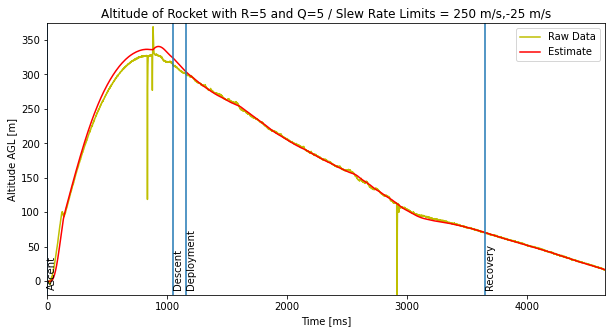

In [7]:
plt.figure(figsize=(10, 5))
plt.plot(agl, 'y', label="Raw Data")
# plt.plot(agl_avrg, 'b', label=f"Running Avarage of {N} samples")
#plt.plot(agl_avrg_limited, 'b', label=f"Running Avarage of {N} samples")
plt.plot(agl_estimate, 'r', label="Estimate")

plt.axvline(x=0)
plt.text(0,-10,"Ascent",rotation=90)
plt.axvline(x=descent_state_transition)
plt.text(descent_state_transition,-10,"Descent",rotation=90)
plt.axvline(x=deploy_state_transition)
plt.text(deploy_state_transition,-10,"Deployment",rotation=90)
plt.axvline(x=deploy_state_transition+BURN_TIME*100)


plt.text(deploy_state_transition+BURN_TIME*100,-10,"Recovery",rotation=90)
#plt.text(deploy_state_transition+BURN_TIME*100,-10,"Estimated Cut",rotation=90)

#plt.axhline(y=100, color='r', linestyle='-')

plt.legend()

axes = plt.gca()
axes.set_xlim(plot_limits)

# Add title and axis names
#plt.title(f"Altitude of Rocket with R={R_num} and Q={Q_num}" if rate_limit_enable == False else f"Altitude of Rocket with R={R_num} and Q={Q_num} / Slew Rate Limits = {rate_R_before} m/s,{rate_F} m/s")
plt.title("Altitude")
plt.xlabel('Time [ms]')
plt.ylabel('Altitude AGL [m]')

plt.ylim((-20,agl_estimate.max()+agl_estimate.max()*0.1))

#plt.savefig(f'altitude-{name}-{R_num}.pdf')
plt.savefig('altitude.pdf')
plt.show()

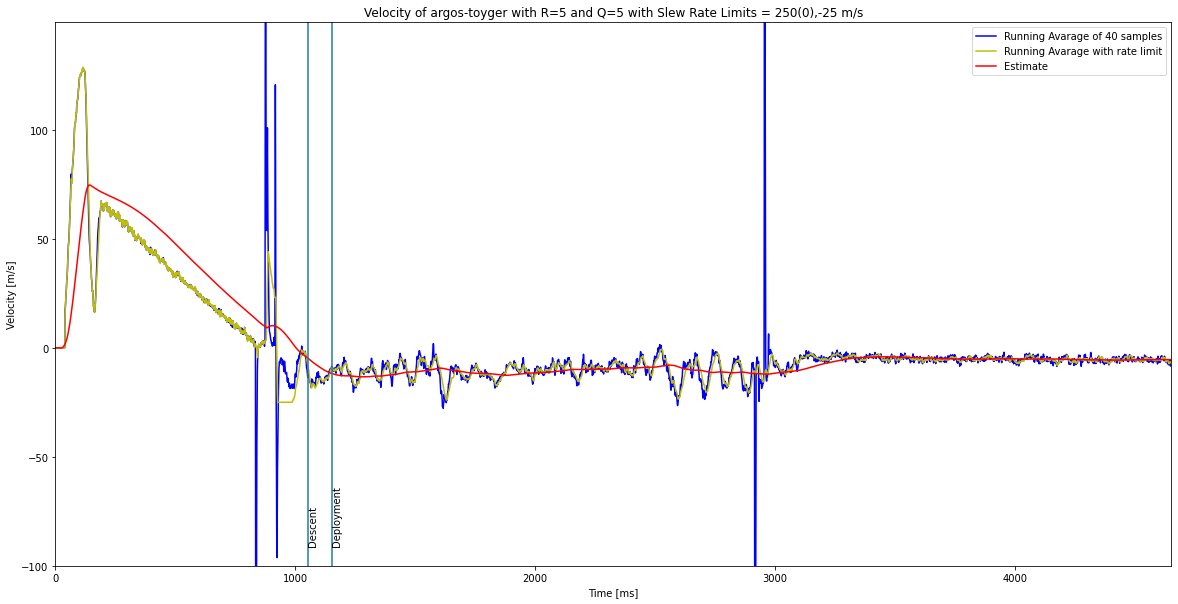

In [8]:
plt.figure(figsize=(20, 10))
plt.plot(speed_avrg, 'b', label=f"Running Avarage of {N} samples")
plt.plot(speed_avrg_limited, 'y', label=f"Running Avarage with rate limit")
plt.plot(velocity_estimate, 'r', label="Estimate")

plt.axvline(x=descent_state_transition)
plt.text(descent_state_transition,-90,"Descent",rotation=90)
plt.axvline(x=deploy_state_transition)
plt.text(deploy_state_transition,-90,"Deployment",rotation=90)

plt.legend()

axes = plt.gca()
axes.set_xlim(plot_limits)

# Add title and axis names
plt.title(f"Velocity of Rocket with R={R_num} and Q={Q_num}" if rate_limit_enable == False else f"Velocity of {name} with R={R_num} and Q={Q_num} with Slew Rate Limits = {rate_R_before}({rate_R}),{rate_F} m/s")
plt.xlabel('Time [ms]')
plt.ylabel('Velocity [m/s]')

plt.ylim((-100,velocity_estimate.max() *2))

plt.show()